<a href="https://colab.research.google.com/github/Ahmed-A-Mohamed/Machine-Learning-NU/blob/master/Differential_abundance_machine_learning_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This project is taken form this
https://github.com/cstub/ml-ids/blob/master/notebooks/03_ml-prototype/ml-prototype.ipynb

# **1. Dataset Preparation**

## The steps in R
1. preprocessing step through ANCOM-2
2. create the data

```
# preprocessing through ANCOM2
source("ancom.R")
  otu_data = physeq@otu_table
  otu_data =physeq@otu_table[ sort(rownames(physeq@otu_table)) ,]
  #rownames(otu_data) <- 1:nrow(otu_data)
  meta_data = physeq@sam_data
  meta_data$IDD <- as.character(1:(length(rownames(meta_data))))
  meta_data$Sample.ID <- rownames(meta_data)
  #meta_data$numbering = c(1:nrow(meta_data))
  #for ( i in levels(factor(meta_data$ID))){ meta_data$wave[meta_data[(meta_data$ID == levels(factor(meta_data$ID))[1]),]$numbering] = c(1:length(meta_data[(meta_data$ID == levels(factor(meta_data$ID))[2]),]$numbering))}
  #rownames(meta_data) = paste0(rownames(meta_data),"_",meta_data$wave)
  #colnames(otu_data) = rownames(meta_data)
  feature_table = otu_data; sample_var = "Sample.ID"; group_var = NULL
  out_cut = 0.05; zero_cut = 0.90; lib_cut = 1000; neg_lb = FALSE
  prepro = feature_table_pre_process(feature_table, meta_data, sample_var, group_var,
                                     out_cut, zero_cut, lib_cut, neg_lb)
  feature_table = prepro$feature_table # Preprocessed feature table
  meta_data = prepro$meta_data # Preprocessed metadata
  struc_zero = prepro$structure_zeros # Structural zero info
  
# create our simulated data  
df = as.data.frame(t(feature_table))


# add column label from the variable of group
df$label <- meta_data$group
# df$label = physeq@sam_data$bmi_group # for dietswap data
```

3. save the data in csv file


```
write.csv(df, file = paste0(getwd(),"/data.csv" ) )
# write.csv(df, file = paste0(getwd(),"/dietswap_data.csv" ) ) # # for dietswap data
```




In [ ]:
pip install shap scikit-plot catboost eli5

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
import shap
import scikitplot as skplt
import eli5
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, precision_recall_curve, average_precision_score
from catboost import CatBoostClassifier
from catboost import Pool
from eli5.sklearn import PermutationImportance
from scipy.stats import spearmanr
from scipy.cluster import hierarchy
from collections import defaultdict
from scipy.stats import ks_2samp
from scipy.stats import describe
from imblearn.over_sampling import SMOTENC
from collections import Counter
from IPython.display import display
from sklearn import metrics
from sklearn.model_selection import GroupKFold

%matplotlib inline

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Dr. M. Mysara/ML/data.csv")

In [ ]:
# this data is taken from otu_table(physeq) in r
df = pd.DataFrame(df)

df.head()

NameError: ignored

In [ ]:
# change the type of all columns into integer (int64) except target column (object type) and sample names
df[df.columns[1:-1]] = df[df.columns[1:-1]].astype('float64')

df[df.columns[-1]] = df[df.columns[-1]].astype('category')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47 entries, 0 to 46
Data columns (total 98 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   Unnamed: 0         47 non-null     object  
 1   OTU_97.1012        47 non-null     float64 
 2   OTU_97.10385       47 non-null     float64 
 3   OTU_97.1047        47 non-null     float64 
 4   OTU_97.10566       47 non-null     float64 
 5   OTU_97.1066        47 non-null     float64 
 6   OTU_97.1131        47 non-null     float64 
 7   OTU_97.11779       47 non-null     float64 
 8   OTU_97.1179        47 non-null     float64 
 9   OTU_97.12204       47 non-null     float64 
 10  OTU_97.1226        47 non-null     float64 
 11  OTU_97.1233-TPup   47 non-null     float64 
 12  OTU_97.1244        47 non-null     float64 
 13  OTU_97.12535       47 non-null     float64 
 14  OTU_97.13133       47 non-null     float64 
 15  OTU_97.13820       47 non-null     float64 
 16  OTU_97.140

In [ ]:
# Rename the first column
df.rename(columns={'Unnamed: 0': 'SamplesID'}, inplace=True)


# Set the 'unamed:0' column as the row index
df.set_index('SamplesID', inplace=True)

df.head

<bound method NDFrame.head of            OTU_97.1012  OTU_97.10385  OTU_97.1047  OTU_97.10566  OTU_97.1066  \
SamplesID                                                                      
V1            0.736866      2.290002    -0.394798     -0.825788    -1.599671   
V2            1.479846      5.845888     1.131668     -3.166771     2.408869   
V3            0.593400     -3.068419     0.463532     -3.068419    -3.068419   
V4            0.970694     -1.878047     0.294362     -1.878047    -1.878047   
V5            1.337170     -3.383380     0.801956      0.238358    -3.383380   
V6            0.876499      0.930403    -0.063125     -1.296336    -1.296336   
V7            1.221935      0.403355     0.979892     -1.695036    -1.695036   
V8            1.150910     -1.372173    -0.899969     -1.372173    -1.372173   
V9            1.123903     -1.759066     0.032310     -1.273735    -1.759066   
V10           1.196445     -0.820392     0.628234     -1.171531    -0.820392   
V11       

In [ ]:
df['label_cat'] = df.label.astype('category').cat.codes

df.head()

,OTU_97.1012,OTU_97.10385,OTU_97.1047,OTU_97.10566,OTU_97.1066,OTU_97.1131,OTU_97.11779,OTU_97.1179,OTU_97.12204,OTU_97.1226,...,OTU_97.8146,OTU_97.8161,OTU_97.8260,OTU_97.8585,OTU_97.8644,OTU_97.8972,OTU_97.9140,OTU_97.951,label,label_cat
SamplesID,,,,,,,,,,,,,,,,,,,,,
V1,0.736866,2.290002,-0.394798,-0.825788,-1.599671,-1.599671,-1.599671,-1.599671,-1.599671,-1.599671,...,-1.599671,1.518770,0.135989,0.323240,0.027330,0.551288,-1.139665,0.940488,grp1,0
V2,1.479846,5.845888,1.131668,-3.166771,2.408869,-0.798587,-2.206273,-3.166771,1.479846,-3.166771,...,-3.166771,2.773543,-3.166771,0.699771,3.124318,1.464250,-2.206273,3.136201,grp1,0
V3,0.593400,-3.068419,0.463532,-3.068419,-3.068419,-3.068419,0.990267,-0.345510,-0.718662,-3.068419,...,-1.320696,1.896140,7.731443,-0.074385,-3.068419,0.811394,1.632560,3.472988,grp1,0
V4,0.970694,-1.878047,0.294362,-1.878047,-1.878047,-1.878047,-1.878047,-1.878047,-1.878047,-0.739683,...,2.959645,2.312579,-0.996580,0.791759,-1.878047,4.183101,-1.878047,0.510814,grp1,0
V5,1.337170,-3.383380,0.801956,0.238358,-3.383380,-3.383380,2.611648,-3.383380,1.291074,-3.383380,...,4.155527,2.665584,-3.383380,0.817227,3.452101,1.415139,-3.383380,4.016060,grp1,0


# **2. Transformation & Normalization**

https://github.com/ntessore/composition_stats


# **3. Model Training Preparation**

## **3.1. Train / Test split**

In order to train and evaluate different models a train/evaluation/test split
is created with the ratios of `0.8/0.1/0.1`.

In [ ]:
def print_report(ds_type, cls, X_vals, y_true, y_predict, plot_pr=False, plot_roc=False):
    print(f"Classification Report ({ds_type}):")
    print(classification_report(y_true, y_predict))
    #print(f"Avg Precision Score: {average_precision_score(y_true, y_predict, average='weighted')}")
    print(metrics.precision_score(y_true, y_predict, average="weighted"))

    if plot_roc:
        print(f"ROC AUC Score: {roc_auc_score(y_true, y_predict)}")
        skplt.metrics.plot_roc(y_true, cls.predict_proba(X_vals))
        plt.show()

    if plot_pr:

        skplt.metrics.plot_precision_recall(y_true, cls.predict_proba(X_vals))
        plt.show()

    print('\n')

In [ ]:
# dtaframe is split into the predictor variable X and the target varaible y
X = df.drop(columns=['label', 'label_cat'])
y = df[['label', 'label_cat']]

In [ ]:
#X_train, X_hold, y_train, y_hold = train_test_split(X, y, test_size=0.2, stratify=y.label_cat)
#X_eval, X_test, y_eval, y_test = train_test_split(X_hold, y_hold, test_size=0.5, stratify=y_hold.label_cat)

# split into train test sets
x_train, x_test, y_train, y_test = train_test_split(X, y.label_cat, test_size = 0.3, random_state = 42, stratify=y.label_cat)


In [ ]:
y.label.value_counts()


grp2    24
grp1    23
Name: label, dtype: int64

In [ ]:
X

,OTU_97.1012,OTU_97.10385,OTU_97.1047,OTU_97.10566,OTU_97.1066,OTU_97.1131,OTU_97.11779,OTU_97.1179,OTU_97.12204,OTU_97.1226,...,OTU_97.7138-TPup,OTU_97.722,OTU_97.8146,OTU_97.8161,OTU_97.8260,OTU_97.8585,OTU_97.8644,OTU_97.8972,OTU_97.9140,OTU_97.951
SamplesID,,,,,,,,,,,,,,,,,,,,,
V1,0.736866,2.290002,-0.394798,-0.825788,-1.599671,-1.599671,-1.599671,-1.599671,-1.599671,-1.599671,...,1.492599,-1.599671,-1.599671,1.518770,0.135989,0.323240,0.027330,0.551288,-1.139665,0.940488
V2,1.479846,5.845888,1.131668,-3.166771,2.408869,-0.798587,-2.206273,-3.166771,1.479846,-3.166771,...,5.375525,-3.166771,-3.166771,2.773543,-3.166771,0.699771,3.124318,1.464250,-2.206273,3.136201
V3,0.593400,-3.068419,0.463532,-3.068419,-3.068419,-3.068419,0.990267,-0.345510,-0.718662,-3.068419,...,-3.068419,-1.320696,-1.320696,1.896140,7.731443,-0.074385,-3.068419,0.811394,1.632560,3.472988
V4,0.970694,-1.878047,0.294362,-1.878047,-1.878047,-1.878047,-1.878047,-1.878047,-1.878047,-0.739683,...,0.839583,-1.878047,2.959645,2.312579,-0.996580,0.791759,-1.878047,4.183101,-1.878047,0.510814
V5,1.337170,-3.383380,0.801956,0.238358,-3.383380,-3.383380,2.611648,-3.383380,1.291074,-3.383380,...,-3.383380,-1.427931,4.155527,2.665584,-3.383380,0.817227,3.452101,1.415139,-3.383380,4.016060
V6,0.876499,0.930403,-0.063125,-1.296336,-1.296336,-1.296336,-1.296336,-1.296336,-1.296336,-1.296336,...,-1.296336,-1.296336,-1.296336,1.768491,-1.296336,-0.063125,-0.899947,0.626066,-1.296336,-0.215960
V7,1.221935,0.403355,0.979892,-1.695036,-1.695036,2.588970,2.253629,-1.695036,2.599869,-1.695036,...,-1.695036,-1.695036,-0.743546,2.190375,3.264105,0.496375,-1.695036,1.083837,-1.695036,-0.264933
V8,1.150910,-1.372173,-0.899969,-1.372173,-1.372173,-1.372173,-1.372173,-1.372173,-1.372173,-1.372173,...,-1.372173,0.737107,1.478255,1.852327,2.142066,0.158471,-0.899969,0.158471,-0.899969,-1.372173
V9,1.123903,-1.759066,0.032310,-1.273735,-1.759066,-1.759066,-0.948391,-1.273735,0.693671,-1.759066,...,-1.759066,-1.759066,2.041576,2.159978,-1.273735,0.693671,0.795797,0.451542,2.159978,-1.759066


In [ ]:
percentage_benign = len(y_train[y_train == 0]) / len(y_train)

print('Class occurences:')
print(y_train.value_counts())
print('Percentage of benign samples: %.4f' % percentage_benign)

Class occurences:
1    16
0    16
Name: label_cat, dtype: int64
Percentage of benign samples: 0.5000


*The distribution of classes shows that the dataset is highly balanced*

# **4. Classifiers**


## **4.1 Random Forest**

- https://towardsdatascience.com/random-forest-in-python-24d0893d51c0

>1, train: 0.688, test: 0.400
>2, train: 0.906, test: 0.667
>3, train: 0.969, test: 0.800
>4, train: 1.000, test: 0.600
>5, train: 1.000, test: 0.667
>6, train: 1.000, test: 0.733
>7, train: 0.969, test: 0.733
>8, train: 1.000, test: 0.933
>9, train: 1.000, test: 0.867
>10, train: 1.000, test: 0.867
>11, train: 1.000, test: 0.533
>12, train: 1.000, test: 1.000
>13, train: 1.000, test: 0.800
>14, train: 0.969, test: 0.733
>15, train: 1.000, test: 0.733
>16, train: 1.000, test: 1.000
>17, train: 1.000, test: 0.800
>18, train: 0.938, test: 0.800
>19, train: 1.000, test: 0.733
>20, train: 1.000, test: 0.733
>21, train: 1.000, test: 0.800
>22, train: 0.969, test: 0.800
>23, train: 0.969, test: 0.400
>24, train: 0.906, test: 0.533
>25, train: 1.000, test: 1.000
>26, train: 1.000, test: 0.667
>27, train: 0.969, test: 0.600
>28, train: 0.969, test: 0.667
>29, train: 1.000, test: 0.600
>30, train: 0.969, test: 0.867
>31, train: 1.000, test: 0.867
>32, train: 1.000, test: 0.600
>33, train: 1.000

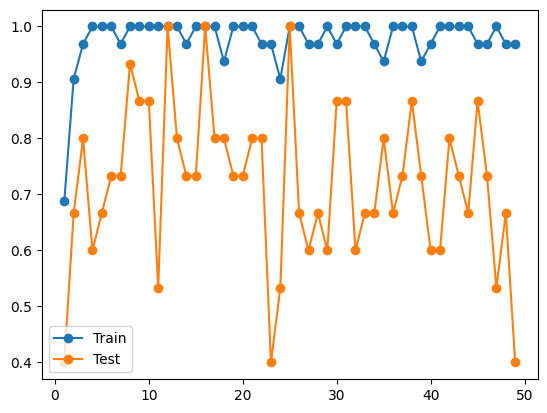

In [ ]:
# https://machinelearningmastery.com/overfitting-machine-learning-models/
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from matplotlib import pyplot

# Feature Scaling
from sklearn.preprocessing import StandardScaler
columns = x_train.columns
scalerx = StandardScaler()
x_train_scaled = scalerx.fit_transform(x_train)
x_train_scaled = pd.DataFrame(x_train_scaled, columns = columns)

x_test_scaled = scalerx.transform(x_test)
x_test_scaled = pd.DataFrame(x_test_scaled, columns = columns)

# define lists to collect scores
train_scores, test_scores = list(), list()
# define the tree depths to evaluate
values = [i for i in range(1, 50)]
# evaluate a decision tree for each depth
for i in values:
	# configure the model
	model = RandomForestClassifier(n_estimators=10, max_depth = i)
	# fit model on the training dataset
	model.fit(x_train_scaled, y_train)
	# evaluate on the train dataset
	train_yhat = model.predict(x_train_scaled)
	train_acc = accuracy_score(y_train, train_yhat)
	train_scores.append(train_acc)
	# evaluate on the test dataset
	test_yhat = model.predict(x_test_scaled)
	test_acc = accuracy_score(y_test, test_yhat)
	test_scores.append(test_acc)
	# summarize progress
	print('>%d, train: %.3f, test: %.3f' % (i, train_acc, test_acc))
# plot of train and test scores vs tree depth
pyplot.plot(values, train_scores, '-o', label='Train')
pyplot.plot(values, test_scores, '-o', label='Test')
pyplot.legend()
pyplot.show()


Classification Report (Train):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       1.00      1.00      1.00        16

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32

1.0


Classification Report (Test):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         8

    accuracy                           1.00        15
   macro avg       1.00      1.00      1.00        15
weighted avg       1.00      1.00      1.00        15

1.0


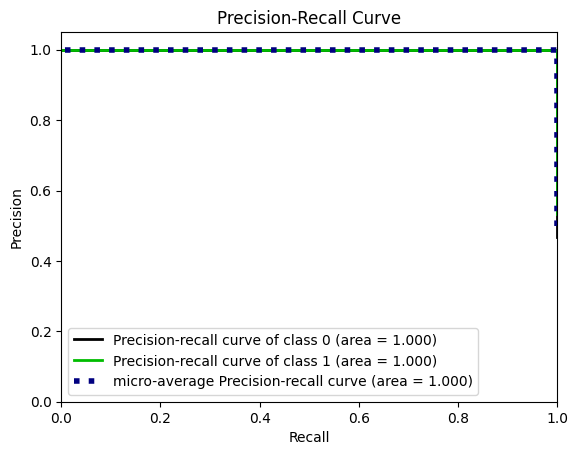

In [ ]:
cls_forest = RandomForestClassifier(random_state=42)
cls_forest.fit(x_train, y_train)

print_report('Train', cls_forest, x_train, y_train, cls_forest.predict(x_train))
print_report('Test', cls_forest, x_test, y_test, cls_forest.predict(x_test), plot_pr=True)

## **4.2 Gradient Boosting**

In [ ]:
from catboost import CatBoostClassifier, Pool

train_pool = Pool(data = x_train.values, label = y_train.values)
test_pool = Pool(x_test.values)

In [ ]:
minority_class_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

cls_cb = CatBoostClassifier()

cls_cb.fit(train_pool)

Learning rate set to 0.002369
0:	learn: 0.6918043	total: 60.8ms	remaining: 1m
1:	learn: 0.6897388	total: 72.5ms	remaining: 36.2s
2:	learn: 0.6877782	total: 83.6ms	remaining: 27.8s
3:	learn: 0.6853307	total: 94.4ms	remaining: 23.5s
4:	learn: 0.6832199	total: 104ms	remaining: 20.8s
5:	learn: 0.6808294	total: 114ms	remaining: 18.9s
6:	learn: 0.6786811	total: 124ms	remaining: 17.6s
7:	learn: 0.6770002	total: 133ms	remaining: 16.5s
8:	learn: 0.6752411	total: 142ms	remaining: 15.6s
9:	learn: 0.6731257	total: 153ms	remaining: 15.1s
10:	learn: 0.6717197	total: 159ms	remaining: 14.3s
11:	learn: 0.6701015	total: 165ms	remaining: 13.6s
12:	learn: 0.6688050	total: 171ms	remaining: 12.9s
13:	learn: 0.6669267	total: 176ms	remaining: 12.4s
14:	learn: 0.6650659	total: 182ms	remaining: 11.9s
15:	learn: 0.6637724	total: 187ms	remaining: 11.5s
16:	learn: 0.6622754	total: 197ms	remaining: 11.4s
17:	learn: 0.6609147	total: 207ms	remaining: 11.3s
18:	learn: 0.6593580	total: 213ms	remaining: 11s
19:	learn: 0

In [ ]:
print_report('Train', cls_cb, train_pool, y_train, cls_cb.predict(train_pool))

Classification Report (Train):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       1.00      1.00      1.00        16

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32

1.0




Classification Report (Test):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         8

    accuracy                           1.00        15
   macro avg       1.00      1.00      1.00        15
weighted avg       1.00      1.00      1.00        15

1.0


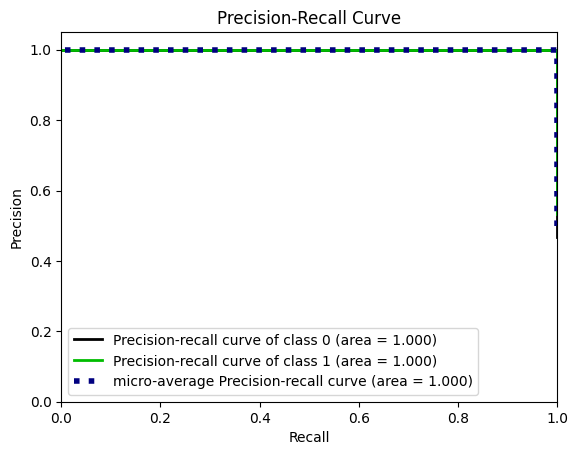

In [ ]:
print_report('Test', cls_cb, test_pool, y_test, cls_cb.predict(test_pool), plot_pr=True)

# **5. Feature importance**

In [ ]:
## Random forest

perm = PermutationImportance(cls_forest, scoring='recall_weighted', n_iter=3).fit(x_test, y_test) # Random forest
eli5.show_weights(perm, feature_names=x_test.columns.tolist())

Weight,Feature
0.3333 ± 0.1089,OTU_97.209-TPup
0.2222 ± 0.1663,OTU_97.1233-TPup
0 ± 0.0000,OTU_97.24076
0 ± 0.0000,OTU_97.1825
0 ± 0.0000,OTU_97.18367-TPup
0 ± 0.0000,OTU_97.18945
0 ± 0.0000,OTU_97.19749
0 ± 0.0000,OTU_97.1984
0 ± 0.0000,OTU_97.19949
0 ± 0.0000,OTU_97.21920


In [ ]:
from sklearn.inspection import permutation_importance

result = permutation_importance(cls_forest, X, y.label_cat, n_repeats=10, random_state=42)

perm_importances = result.importances_mean
perm_std = result.importances_std
sorted_idx = perm_importances.argsort()
feature_names = X.columns

pd.DataFrame({'Importance': perm_importances, 'Std': perm_std}, index=feature_names[sorted_idx]).sort_values('Importance',ascending=False)

,Importance,Std
OTU_97.43403,0.106383,0.023307
OTU_97.41674,0.074468,0.025620
OTU_97.1012,0.000000,0.000000
OTU_97.12204,0.000000,0.000000
OTU_97.9140,0.000000,0.000000
...,...,...
OTU_97.8146,0.000000,0.000000
OTU_97.8161,0.000000,0.000000
OTU_97.8260,0.000000,0.000000
OTU_97.8585,0.000000,0.000000


In [ ]:
import pandas as pd
feature_imp = pd.Series(cls_forest.feature_importances_,index=X.columns).sort_values(ascending=False)
feature_imp

OTU_97.209-TPup     0.144111
OTU_97.1233-TPup    0.093358
OTU_97.597          0.024210
OTU_97.31833        0.023583
OTU_97.8585         0.019619
                      ...   
OTU_97.1131         0.000317
OTU_97.13133        0.000000
OTU_97.1401         0.000000
OTU_97.9140         0.000000
OTU_97.286          0.000000
Length: 96, dtype: float64

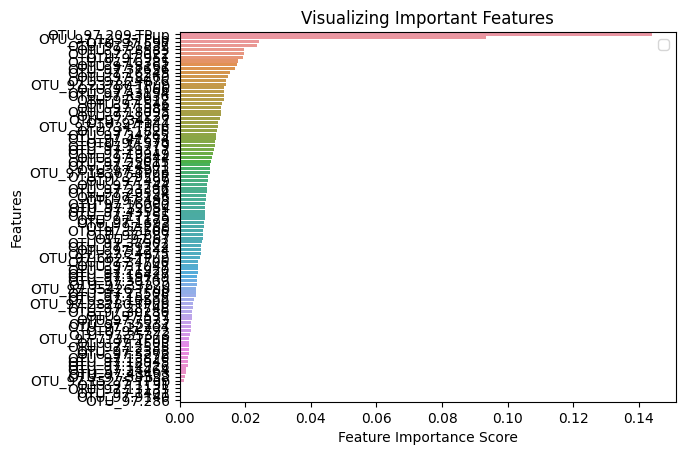

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

In [ ]:
## Gradient Boosting

estimator = cls_cb # cls_cb for Gradient Boosting

perm = PermutationImportance(estimator, scoring='recall_weighted', n_iter=3).fit(x_test, y_test)
eli5.show_weights(perm, feature_names=x_test.columns.tolist())

Weight,Feature
0.4667 ± 0.1886,OTU_97.209-TPup
0.0889 ± 0.1663,OTU_97.1233-TPup
0 ± 0.0000,OTU_97.24076
0 ± 0.0000,OTU_97.1825
0 ± 0.0000,OTU_97.18367-TPup
0 ± 0.0000,OTU_97.18945
0 ± 0.0000,OTU_97.19749
0 ± 0.0000,OTU_97.1984
0 ± 0.0000,OTU_97.19949
0 ± 0.0000,OTU_97.21920


In [ ]:
import pandas as pd
feature_imp = pd.Series(estimator.feature_importances_,index=X.columns).sort_values(ascending=False)
feature_imp

OTU_97.41706         15.441075
OTU_97.15051-TPup     6.172022
OTU_97.13820          4.698631
OTU_97.3911           3.875510
OTU_97.4904           3.357110
                       ...    
OTU_97.6931           0.094280
OTU_97.1828           0.075410
OTU_97.1099           0.058735
OTU_97.293            0.034722
OTU_97.13133          0.015528
Length: 95, dtype: float64

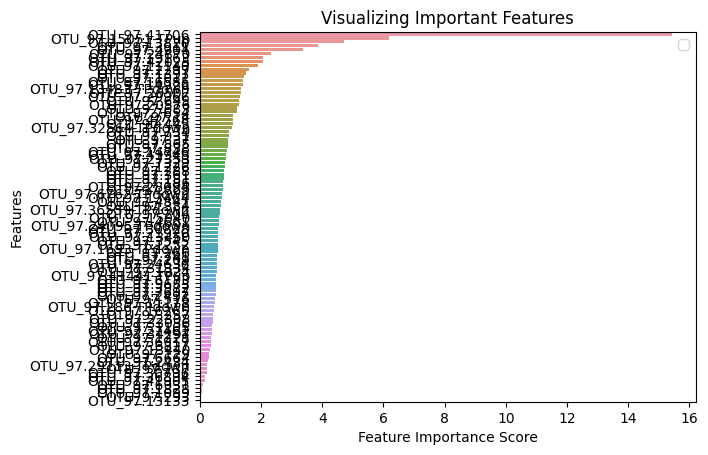

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

In [ ]:
# Feature Importance and Binary Classification using PyCaret
# https://medium.com/@p98718/feature-importance-and-binary-classification-using-pycaret-a94b9a6a5b03#:~:text=Feature%20importance%20quantifies%20the%20relative,informative%20in%20making%20accurate%20predictions.
!pip install pycaret
!pip install --upgrade scipy
!pip install --upgrade numpy
!pip uninstall scipy
!pip install scipy

from scipy._lib._util import prod


import pandas as pd
from pycaret.classification import *

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 39.7 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.10.1
    Uninstalling scipy-1.10.1:
      Successfully uninstalled scipy-1.10.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pycaret 3.1.0 requires scipy~=1.10.1, but you have scipy 1.11.3 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 42.7 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cupy-cuda11x 11.0.0 requires numpy<1.26,>=1.20, but you have numpy 1.26.0 which is incompatible.
nu

ImportError: ignored

In [ ]:
df.info()

**################################################################################**

# **Mixed Effects Random Forests**

## **The preprocessing steps in R**
1. preprocessing step through ANCOM-2
2. create the data

```R
df = as.data.frame(t(physeq@otu_table))


# Apply CLR trasnforamtion
df = as.data.frame(clr(df))

# add column label from the variable of group
df$label = physeq@sam_data$bmi_group # for dietswap data
df$time = physeq@sam_data$timepoint.within.group
df$id = physeq@sam_data$subject
```

3. save the data in csv file


```R
df = as.data.frame(df)

write.csv(df, file = paste0(getwd(),"/dietswap_data.csv" ) ) # # for dietswap data
```




In [ ]:
# import csv of longitudinal data (dietswap)
df = pd.read_csv("/content/drive/MyDrive/Dr. M. Mysara/ML/dietswap_data.csv")
#df = pd.read_csv("/content/drive/MyDrive/Dr. M. Mysara/ML/data_longi.csv")

In [ ]:
# https://towardsdatascience.com/mixed-effects-random-forests-6ecbb85cb177
!pip install merf

## **Importing the data from R**

In [ ]:
# this data is taken from otu_table(physeq) in r
df = pd.DataFrame(df)

df.head()

,Unnamed: 0,Akkermansia,Alcaligenes faecalis et rel.,Allistipes et rel.,Anaerostipes caccae et rel.,Anaerotruncus colihominis et rel.,Anaerovorax odorimutans et rel.,Aquabacterium,Atopobium,Bacillus,...,Uncultured Mollicutes,Uncultured Selenomonadaceae,Veillonella,Vibrio,Weissella et rel.,Xanthomonadaceae,Yersinia et rel.,label,time,id
0,Sample-1,0.406372,-2.484000,3.333111,3.013168,0.000907,-0.692241,0.0,0.000000,-2.484000,...,1.922719,0.0,-0.404559,-1.790853,-2.484000,-2.484000,-1.790853,obese,1,byn
1,Sample-2,1.628287,-2.253277,1.196711,1.973557,1.735707,1.344035,0.0,-2.946424,-2.253277,...,1.180710,0.0,-0.001985,-1.560130,2.246533,-2.946424,-2.253277,lean,1,nms
2,Sample-3,1.051761,-2.054319,0.430587,0.142905,2.160274,0.248266,0.0,0.000000,-3.152932,...,2.784605,0.0,-1.361172,-2.054319,-2.459784,-2.459784,-2.459784,overweight,1,olt
3,Sample-4,2.516719,-2.335312,1.535889,0.555060,1.191049,1.065886,0.0,-3.028459,-3.028459,...,2.294551,0.0,-1.419021,-1.642165,-0.463510,-3.028459,-1.929847,obese,1,pku
4,Sample-5,0.380447,-1.970928,1.227745,0.471419,0.043975,-0.179169,0.0,0.000000,-2.664075,...,-0.466851,0.0,-0.718165,-1.970928,-1.970928,-1.565463,-1.970928,overweight,1,qjy


In [ ]:
# Rename the first column
df.rename(columns={'Unnamed: 0': 'SamplesID'}, inplace=True)


# Set the 'unamed:0' column as the row index
df.set_index('SamplesID', inplace=True)

# add column similar to target but in numerical form
df['label_cat'] = df.label.astype('category').cat.codes

df.head

<bound method NDFrame.head of             Akkermansia  Alcaligenes faecalis et rel.  Allistipes et rel.  \
SamplesID                                                                   
Sample-1       0.406372                     -2.484000            3.333111   
Sample-2       1.628287                     -2.253277            1.196711   
Sample-3       1.051761                     -2.054319            0.430587   
Sample-4       2.516719                     -2.335312            1.535889   
Sample-5       0.380447                     -1.970928            1.227745   
...                 ...                           ...                 ...   
Sample-218    -0.118655                     -0.811802            2.050399   
Sample-219    -0.178453                     -1.277066            3.677352   
Sample-220     0.478532                     -1.919363            1.635985   
Sample-221     1.467943                     -2.156398            2.225629   
Sample-222     0.486468                     -2

## **Splitting (repeated measures)**
**you want to ensure that all measurements from the same group are either in the training or test set, you can use `GroupKFold` from `sklearn.model_selection`.**

In [ ]:
# Define the number of splits or folds you want (e.g., 5 for 80/20 split)
n_splits = 4 # <<<<<<<<<<<<<<<<<<<<>>>>>>>>>>>>>>>>>>>

# Initialize the GroupKFold
gkf = GroupKFold(n_splits=n_splits)

# Perform the repeated measures cross-validation split
for train_index, test_index in gkf.split(df, groups=df['id']):
    train_data = df.iloc[train_index]
    test_data = df.iloc[test_index]

    # Now, you can use train_data and test_data for training and testing
    # For example:
    X_train = train_data.drop(columns=['label', 'label_cat','time','id'])
    y_train = train_data['label_cat']
    Z_train = train_data[['time']]
    Cluster_train = train_data['id']

    X_test = test_data.drop(columns=['label', 'label_cat','time','id'])
    y_test = test_data['label_cat']
    Z_test = test_data[['time']]
    Cluster_test = test_data['id']

## **Hyperparameter tuning**

In [ ]:
# Perform an iterative grid search using cross-validation to find the best combination of hyperparameters
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score
import numpy as np
from merf import MERF

# Define the hyperparameters you want to test
param_grid = {
    'n_estimators': [50, 100, 150, 200],  # Adjust the number of trees
    'max_depth': [None, 10, 20, 30]  # Adjust the maximum depth
}

# Define the number of splits or folds you want (e.g., 5 for 80/20 split)
n_splits = 4 # <<<<<<<<<<<<<<<<<<<<>>>>>>>>>>>>>>>>>>>

# Initialize the GroupKFold
gkf = GroupKFold(n_splits=n_splits)


clf = RandomForestClassifier()

grid_search = GridSearchCV(clf, param_grid, cv=gkf, scoring='accuracy')  # You can adjust the number of folds (cv) for cross-validation

# Concatenation X and y
X = pd.DataFrame(pd.concat([X_train,X_test],axis=0) ) # Concatenate along rows
y = pd.DataFrame(pd.concat([y_train,y_test],axis=0) ) # Concatenate along rows
Z = pd.DataFrame(pd.concat([Z_train,Z_test],axis=0) )
Cluster = pd.concat([Cluster_train,Cluster_test],axis=0)

# Fit the model with the grid search to find the best hyperparameters
grid_search.fit(X, y, groups=Cluster)

best_n_estimators = grid_search.best_params_['n_estimators']
best_max_depth = grid_search.best_params_['max_depth']
best_score = grid_search.best_score_

print("Best n_estimators: " + str(best_n_estimators))
print("Best max_depth: " + str(best_max_depth))
print("Best score: " + str(best_score))


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the

Best n_estimators: 200
Best max_depth: 30
Best score: 0.3363662218874012


## **Fitting the model**

In [ ]:
# n_estimators. The number of trees in to train for the random forest.
# max_iterations. The maximum number of iterations to run for the EM model.

from merf import MERF
from sklearn.ensemble import RandomForestRegressor
merf = MERF(RandomForestRegressor(n_estimators=50)) # <<<<<<<<<<<<<<<<<<<<>>>>>>>>>>>>>>>>>>>  MERF(RandomForestRegressor(n_estimators=50), max_iterations=20)

# y is the target variable.
# X is the fixed effect features. = all taxa
# Z is the random effect features. = time column
# i is the cluster index. = ID (repeated measures)
merf.fit(X_train, Z_train, Cluster_train, y_train)
y_hat = merf.predict(X_test, Z_test, Cluster_test)

## **Feature importance**

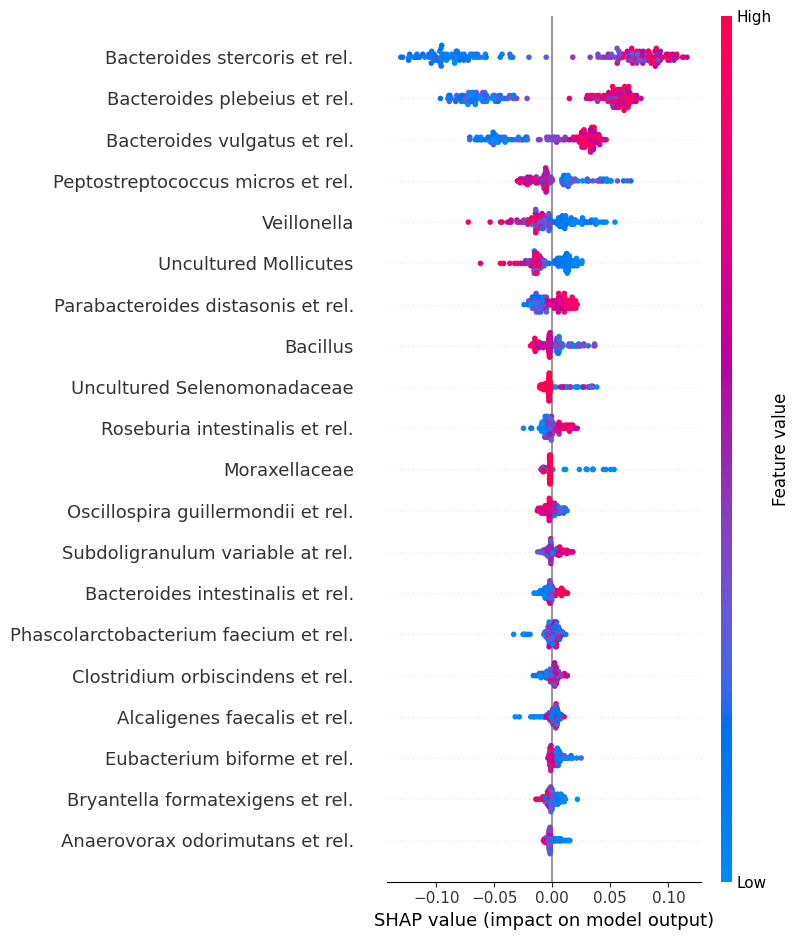

In [ ]:
# explain the model's predictions using SHAP https://notebook.community/manifoldai/merf/notebooks/MERF%20Example
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.TreeExplainer(merf.trained_fe_model)
shap_values = explainer.shap_values(X_train)

# summarize the effects of all the features
shap.summary_plot(shap_values, X_train)

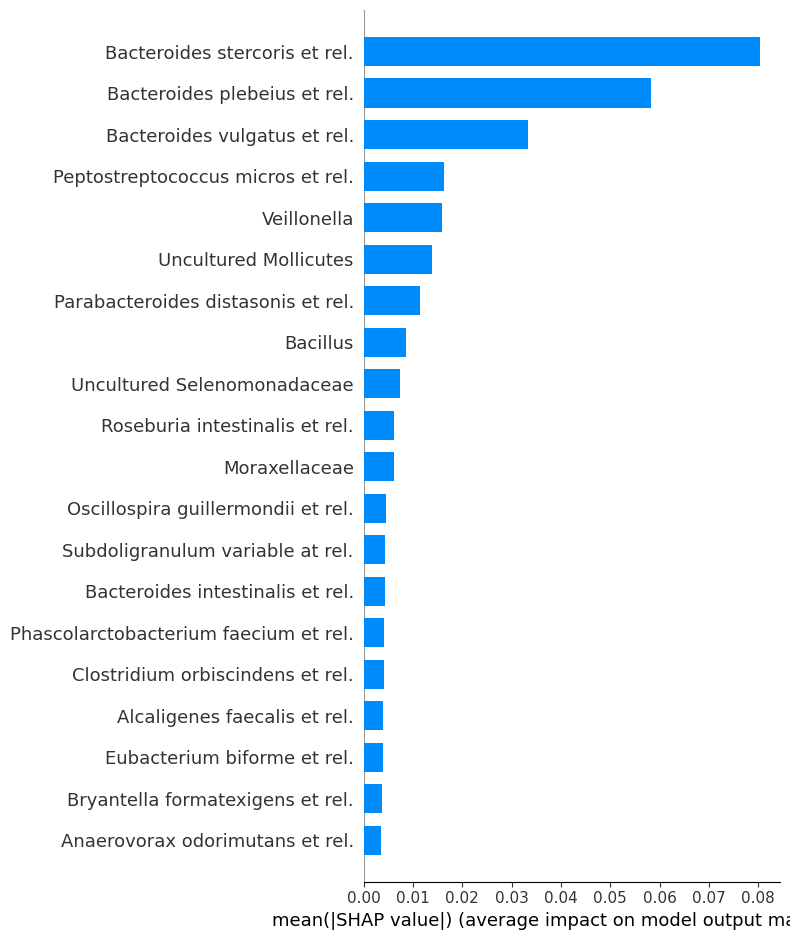

In [ ]:
shap.summary_plot(shap_values, X_train, plot_type="bar")

################################################################################

# **GPBoost: Combining Tree-Boosting with Gaussian Process and Mixed Effects Models**

In [ ]:
# Installaltion
!pip install setuptools -U
!pip install gpboost -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 807.9/807.9 kB 4.0 MB/s eta 0:00:00
  Attempting uninstall: setuptools
    Found existing installation: setuptools 67.7.2
    Uninstalling setuptools-67.7.2:
      Successfully uninstalled setuptools-67.7.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.34.0 requires jedi>=0.16, which is not installed.


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 9.8 MB/s eta 0:00:00


In [ ]:
# https://towardsdatascience.com/tree-boosted-mixed-effects-models-4df610b624cb

# Simulate data
import gpboost as gpb
import numpy as np
import sklearn.datasets as datasets
import time
import pandas as pd
# Simulate data
ntrain = 5000 # number of samples for training
n = 2 * ntrain # combined number of training and test data
m = 500  # number of categories / levels for grouping variable
sigma2_1 = 1  # random effect variance
sigma2 = 1 ** 2  # error variance
# Simulate non-linear mean function
np.random.seed(1)
X, F = datasets.make_friedman3(n_samples=n)
X = pd.DataFrame(X,columns=['variable_1','variable_2','variable_3','variable_4'])
F = F * 10**0.5 # with this choice, the fixed-effects regression function has the same variance as the random effects
# Simulate random effects
group_train = np.arange(ntrain)  # grouping variable
for i in range(m):
    group_train[int(i * ntrain / m):int((i + 1) * ntrain / m)] = i
group_test = np.arange(ntrain) # grouping variable for test data. Some existing and some new groups
m_test = 2 * m
for i in range(m_test):
    group_test[int(i * ntrain / m_test):int((i + 1) * ntrain / m_test)] = i
group = np.concatenate((group_train,group_test))
b = np.sqrt(sigma2_1) * np.random.normal(size=m_test)  # simulate random effects
Zb = b[group]
# Put everything together
xi = np.sqrt(sigma2) * np.random.normal(size=n)  # simulate error term
y = F + Zb + xi  # observed data
# split train and test data
y_train = y[0:ntrain]
y_test = y[ntrain:n]
X_train = X.iloc[0:ntrain,]
X_test = X.iloc[ntrain:n,]

In [ ]:
y_train[:10]

array([1.39835292, 4.84593433, 6.02723583, 1.27364242, 4.90316408,
       2.89303032, 1.77034734, 4.56165269, 4.33496008, 1.78450663])

In [ ]:
y_test[:10]

array([5.59504348, 6.67056751, 6.29588165, 5.95258482, 4.52807964,
       3.03710577, 2.04747663, 4.76638701, 3.1832533 , 2.9768728 ])

In [ ]:
X_train[:10]

,variable_1,variable_2,variable_3,variable_4
0,41.702200,1302.406097,0.000114,4.023326
1,14.675589,276.510637,0.186260,4.455607
2,39.676747,1005.889907,0.419195,7.852195
3,20.445225,1560.181095,0.027388,7.704675
4,41.730480,1038.355154,0.140387,2.981015
5,80.074457,1707.443102,0.313424,7.923226
6,87.638915,1587.118362,0.085044,1.390548
7,16.983042,1560.222046,0.098347,5.211076
8,95.788953,996.657540,0.691877,4.155156
9,68.650093,1489.131723,0.018288,8.501443


In [ ]:
X_test[:10]

,variable_1,variable_2,variable_3,variable_4
5000,80.580204,1010.416157,0.878887,10.475350
5001,83.279029,1757.321118,0.492840,4.999791
5002,17.004338,715.374414,0.896665,10.272294
5003,19.529991,1065.775175,0.254611,8.970284
5004,55.704911,1605.888498,0.577914,2.324425
5005,44.479547,181.412021,0.701272,2.087763
5006,36.887917,456.279978,0.182912,5.203221
5007,76.113060,1482.210570,0.580751,4.156795
5008,31.759361,1239.794019,0.130527,5.398128
5009,3.378975,1514.316082,0.519561,5.138025


In [ ]:
# Learning and making predictions
# Define and train GPModel
gp_model = gpb.GPModel(group_data=group_train)
# create dataset for gpb.train function
data_train = gpb.Dataset(X_train, y_train)
# specify tree-boosting parameters as a dict
params = { 'objective': 'regression_l2', 'learning_rate': 0.1,
    'max_depth': 6, 'min_data_in_leaf': 5, 'verbose': 0 }
# train model
bst = gpb.train(params=params, train_set=data_train, gp_model=gp_model, num_boost_round=31)
gp_model.summary() # estimated covariance parameters

Covariance parameters (random effects):
            Param.
Error_term  0.9253
Group_1     1.0161


In [ ]:
# Make predictions
pred = bst.predict(data=X_test, group_data_pred=group_test)
y_pred = pred['response_mean']
np.sqrt(np.mean((y_test - y_pred) ** 2))

1.2570172939657693

In [ ]:
# Parameter tuning
# Parameter tuning & cross-validation
# Create random effects model and Dataset
gp_model = gpb.GPModel(gp_coords=coords, cov_function="exponential")
data_train = gpb.Dataset(X, y)
# Candidate parameter grid
param_grid = {'learning_rate': [1,0.1,0.01], 'min_data_in_leaf': [1,10,100],
'max_depth': [1,3,5,10]}
# Note: it is advisable to also try larger learning rates (e.g., 1 or larger) since when using
#         gradient boosting the scale of the gradient can depend on the loss function and the data.
#         This is in contrast to Newton boosting, where learning rates smaller than 0.1 are typically used
#         since the natural gradient is not scale dependent.
# Other parameters not contained in the grid of tuning parameters
params = { 'objective': 'regression_l2', 'verbose': 0, 'num_leaves': 2**17 }
# Use a deterministic grid search and cross-validation. Set 'num_try_random' to use a random grid search
opt_params = gpb.grid_search_tune_parameters(
  param_grid=param_grid,
  params=params,
  num_try_random=20,
  nfold=4,
  gp_model=gp_model,
  use_gp_model_for_validation=True,
  train_set=data_train,
  verbose_eval=1,
  num_boost_round=1000,
  early_stopping_rounds=10,
  seed=1,
  metric='l2')
print("Best number of iterations: " + str(opt_params['best_iter']))
print("Best score: " + str(opt_params['best_score']))
print("Best parameters: " + str(opt_params['best_params']))

###########################################################

In [ ]:
# https://htmlpreview.github.io/?https://github.com/fabsig/GPBoost/blob/master/examples/GPBoost_demo.html

import numpy as np
np.random.seed(1)
# Simulate Gaussian process: training and test data (the latter on a grid for visualization)
sigma2_1 = 0.35  # marginal variance of GP
rho = 0.1  # range parameter
sigma2 = 0.1  # error variance
n = 200  # number of training samples
nx = 50 # test data: number of grid points on each axis
# training locations (exclude upper right rectangle)
coords = np.column_stack(
  (np.random.uniform(size=1)/2, np.random.uniform(size=1)/2))
while coords.shape[0] < n:
    coord_i = np.random.uniform(size=2)
    if not (coord_i[0] >= 0.6 and coord_i[1] >= 0.6):
      coords = np.vstack((coords,coord_i))
# test locations (rectangular grid)
s_1 = np.ones(nx * nx)
s_2 = np.ones(nx * nx)
for i in range(nx):
  for j in range(nx):
    s_1[j * nx + i] = (i + 1) / nx
    s_2[i * nx + j] = (i + 1) / nx
coords_test = np.column_stack((s_1, s_2))
n_all = nx**2 + n # total number of data points
coords_all = np.vstack((coords_test,coords))
D = np.zeros((n_all, n_all))  # distance matrix
for i in range(0, n_all):
  for j in range(i + 1, n_all):
    D[i, j] = np.linalg.norm(coords_all[i, :] - coords_all[j, :])
    D[j, i] = D[i, j]
Sigma = sigma2_1 * np.exp(-D / rho) + np.diag(np.zeros(n_all) + 1e-10)
C = np.linalg.cholesky(Sigma)
b_all = C.dot(np.random.normal(size=n_all))
b_train = b_all[(nx*nx):n_all] # training data GP
# Mean function. Use two predictor variables of which only one has an effect for easy visualization
def f1d(x):
  return np.sin(3*np.pi*x) + (1 + 3 * np.maximum(np.zeros(len(x)),x-0.5)/(x-0.5)) - 3
X = np.random.rand(n, 2)
F_X_train = f1d(X[:, 0]) # mean
xi_train = np.sqrt(sigma2) * np.random.normal(size=n)  # simulate error term
y = F_X_train + b_train + xi_train  # observed data
# test data
x = np.linspace(0,1,nx**2)
x[x==0.5] = 0.5 + 1e-10
X_test = np.column_stack((x,np.zeros(nx**2)))
F_X_test = f1d(X_test[:, 0])
b_test = b_all[0:(nx**2)]
xi_test = np.sqrt(sigma2) * np.random.normal(size=(nx**2))
y_test = F_X_test + b_test + xi_test

In [ ]:
X

array([[1.92011599e-01, 5.91627566e-01],
       [6.06831457e-01, 4.41843803e-01],
       [8.64550653e-01, 5.43482186e-01],
       [4.92729711e-01, 4.18125636e-01],
       [6.22251834e-02, 3.62149460e-01],
       [9.28153582e-02, 5.65638500e-01],
       [6.40501632e-01, 7.67782263e-01],
       [6.32535256e-01, 1.87060755e-01],
       [7.50243951e-01, 5.48859400e-01],
       [1.02170359e-01, 2.48270292e-02],
       [2.98746192e-01, 6.90015029e-01],
       [9.32788350e-01, 9.66497201e-01],
       [7.64548089e-01, 2.93249186e-01],
       [6.22069125e-01, 2.31096128e-01],
       [7.50690372e-01, 1.65867029e-01],
       [7.56470386e-01, 8.68588999e-01],
       [5.19506354e-01, 6.56348383e-02],
       [4.48892021e-01, 8.37828611e-01],
       [1.79752653e-01, 3.85590613e-02],
       [7.32693574e-01, 5.63040724e-01],
       [4.20606264e-02, 9.84885264e-01],
       [5.69332387e-01, 5.85156673e-01],
       [7.89906642e-01, 9.02634671e-01],
       [6.07507363e-02, 3.48513209e-01],
       [2.000918

In [ ]:
y

array([-0.56012274,  0.12299291,  2.36337981, -2.65182589, -1.73331144,
       -0.1160212 ,  1.91765966,  0.685626  ,  1.90354825, -0.97547268,
       -2.10027364,  1.16586037,  2.17412448,  0.28118595,  2.65270483,
        1.58551409, -1.06206262, -2.95762045, -0.97478433,  1.30424071,
       -2.14196115, -0.53796643,  1.72235543, -1.36107754, -1.91680212,
       -1.25466989, -1.21843398,  1.40694157, -1.94384033, -1.44574028,
       -2.06229834,  2.11073464, -1.26447858,  1.87102624, -1.4077387 ,
       -3.20633659,  1.53051633,  1.70164502,  0.03305014, -0.20988349,
        1.49916216,  0.31590746, -1.57361538, -1.23211793,  0.54191908,
       -1.28369175,  0.19895487, -1.43028746,  0.7034016 ,  0.34658752,
       -2.00328626, -3.29151157,  0.95114989, -0.3752252 , -0.11905225,
        0.88051378,  2.1313235 , -1.32098774, -1.64138472, -1.4885943 ,
        2.39640455, -0.24657384,  1.61773012,  0.99608663,  2.4121752 ,
        1.37639405, -1.36077485, -0.68757836, -2.17555004,  1.82

In [ ]:
X_test

array([[0.00000000e+00, 0.00000000e+00],
       [4.00160064e-04, 0.00000000e+00],
       [8.00320128e-04, 0.00000000e+00],
       ...,
       [9.99199680e-01, 0.00000000e+00],
       [9.99599840e-01, 0.00000000e+00],
       [1.00000000e+00, 0.00000000e+00]])

In [ ]:
y_test

array([-2.8984179 , -2.27864341, -2.70208728, ...,  1.3693772 ,
        1.11802738,  1.10229907])

In [ ]:
# Training model
import gpboost as gpb
import numpy as np
# Create Gaussian process / random effects model and Dataset
gp_model = gpb.GPModel(gp_coords=coords, cov_function="exponential")
data_train = gpb.Dataset(X, y)
params = { 'objective': 'regression_l2', 'learning_rate': 0.01,
'max_depth': 3, 'min_data_in_leaf': 10, 'num_leaves': 2**10, 'verbose': 0 }
bst = gpb.train(params=params, train_set=data_train, gp_model=gp_model,
                num_boost_round=247)
print("Estimated covariance parameters:")
## Estimated covariance parameters:
gp_model.summary()

Estimated covariance parameters:
Covariance parameters (random effects):
            Param.
Error_term  0.0031
GP_var      0.2896
GP_range    0.0587


In [ ]:
# Prediction
# Make predictions: latent variables and response variable
pred = bst.predict(data=X_test, gp_coords_pred=coords_test, predict_var=True, pred_latent=True)
# pred['fixed_effect']: predictions from the tree-ensemble.
# pred['random_effect_mean']: predicted means of the gp_model.
# pred['random_effect_cov']: predicted (co-)variances of the gp_model
#     (only if 'predict_var' or 'predict_cov' is True).
pred_resp = bst.predict(data=X_test, gp_coords_pred=coords_test, predict_var=False, pred_latent=False)
y_pred = pred_resp['response_mean'] # predicted response mean
print("Mean square error (MSE): " + str(np.mean((y_pred-y_test)**2)))

Mean square error (MSE): 0.3687001707702985


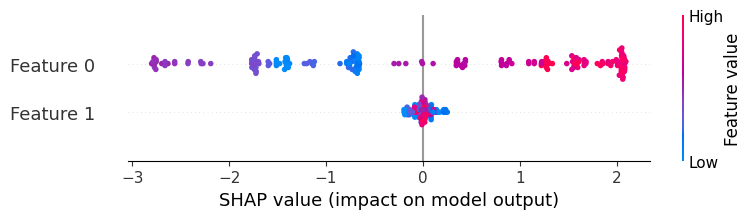

In [ ]:
# model interpretation
import shap
shap_values = shap.TreeExplainer(bst).shap_values(X)
shap.summary_plot(shap_values, X)

In [ ]:
# Parameter tuning & cross-validation
# Create random effects model and Dataset
gp_model = gpb.GPModel(gp_coords=coords, cov_function="exponential")
data_train = gpb.Dataset(X, y)
# Candidate parameter grid
param_grid = {'learning_rate': [1,0.1,0.01], 'min_data_in_leaf': [1,10,100],
'max_depth': [1,3,5,10]}
# Note: it is advisable to also try larger learning rates (e.g., 1 or larger) since when using
#         gradient boosting the scale of the gradient can depend on the loss function and the data.
#         This is in contrast to Newton boosting, where learning rates smaller than 0.1 are typically used
#         since the natural gradient is not scale dependent.
# Other parameters not contained in the grid of tuning parameters
params = { 'objective': 'regression_l2', 'verbose': 0, 'num_leaves': 2**17 }
# Use a deterministic grid search and cross-validation. Set 'num_try_random' to use a random grid search
opt_params = gpb.grid_search_tune_parameters(
  param_grid=param_grid,
  params=params,
  num_try_random=20,
  nfold=4,
  gp_model=gp_model,
  use_gp_model_for_validation=True,
  train_set=data_train,
  verbose_eval=1,
  num_boost_round=1000,
  early_stopping_rounds=10,
  seed=1,
  metric='l2')
print("Best number of iterations: " + str(opt_params['best_iter']))
print("Best score: " + str(opt_params['best_score']))
print("Best parameters: " + str(opt_params['best_params']))

Starting random grid search with 20 trials out of 36 parameter combinations 
Trying parameter combination 1 of 20: {'learning_rate': 1.0, 'min_data_in_leaf': 10, 'max_depth': 10}
***** New best test score (l2 = 0.5375153977136129) found for the following parameter combination:
{'learning_rate': 1.0, 'min_data_in_leaf': 10, 'max_depth': 10, 'num_boost_round': 1}
Trying parameter combination 2 of 20: {'learning_rate': 0.1, 'min_data_in_leaf': 100, 'max_depth': 10}
Trying parameter combination 3 of 20: {'learning_rate': 0.1, 'min_data_in_leaf': 1, 'max_depth': 10}
Trying parameter combination 4 of 20: {'learning_rate': 1.0, 'min_data_in_leaf': 10, 'max_depth': 1}
Trying parameter combination 5 of 20: {'learning_rate': 0.1, 'min_data_in_leaf': 1, 'max_depth': 5}
***** New best test score (l2 = 0.4466125722315536) found for the following parameter combination:
{'learning_rate': 0.1, 'min_data_in_leaf': 1, 'max_depth': 5, 'num_boost_round': 18}
Trying parameter combination 6 of 20: {'learnin